## init

In [2]:
# import sys 
# sys.path.append('pyfiles/')

from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils
)

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
import math
from collections import defaultdict
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance
from scipy.stats import qmc
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import csv
import string

# for polygon grid
from matplotlib.path import Path as mplPath

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

## this is the new, streamlined thing

In [ ]:
our_complex = inp.read_obj("input/blob.obj")
key_point1 = (0.4, 0.6)
key_point2 = (0.6, 0.6)
o = cplx.ordering.by_dist_to(our_complex, key_point1)
o2 = cplx.ordering.by_dist_to(our_complex, key_point2)
matrix = mat.bdmatrix.from_ordering(o)
# with ourplot.PandasMatrix(matrix, o) as p:
#     matrix.reduce(every_step=p.every_step)

bettis = defaultdict(int)
def after_column_reduced(mat, j):
    if mat.get(j, set()):
        death = o.get_simplex(j)
        birth = o.get_simplex(max(mat.get(j, set())))
        bettis[birth.dim()] -= 1
        print(f'col {j}:')
        print(f'  birth={birth}')
        print(f'  death={death}')
    else:
        s = o.get_simplex(j)
        bettis[s.dim()] += 1
        print(f'col {j}: reduced to zero: {s}')

ourplot.plot_orders_with_bubbles(o, o2)

|======== Timed report ========
| initialize_vineyards            :      27.48ms  (27.481ms per; #1)
| vine_to_vine.ordering           :     278.30ms  ( 0.333ms per; #837)
| vine_to_vine.transpositions_lean:     561.91ms  ( 0.671ms per; #837)
| vine_to_vine.matrix copies      :    2814.53ms  ( 3.363ms per; #837)
| perform_one_swap                :   16199.85ms  ( 0.033ms per; #489351)
| dumb loop here                  :   14409.35ms  ( 0.117ms per; #123164)
| vine_to_vine.loop               :   16907.43ms  (20.200ms per; #837)
|==============================


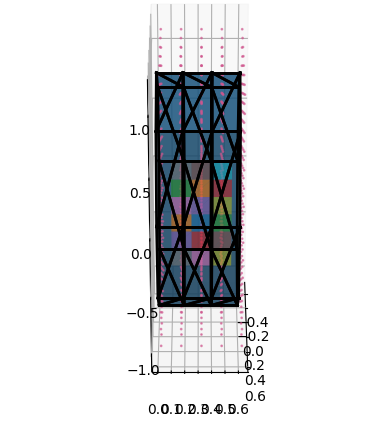

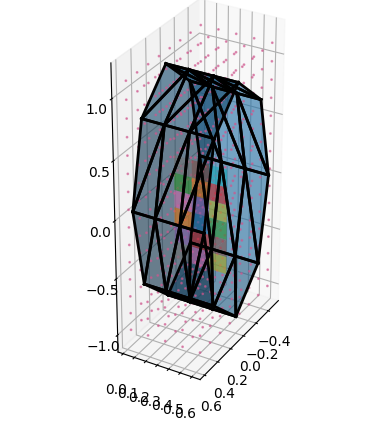

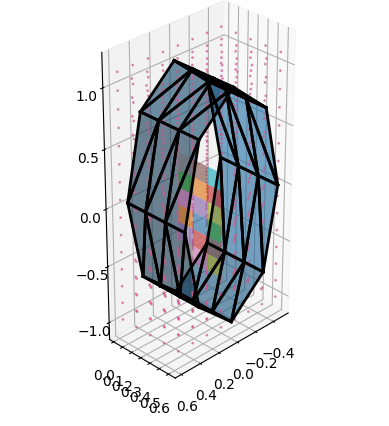

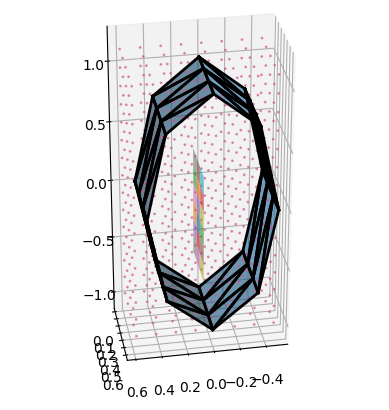

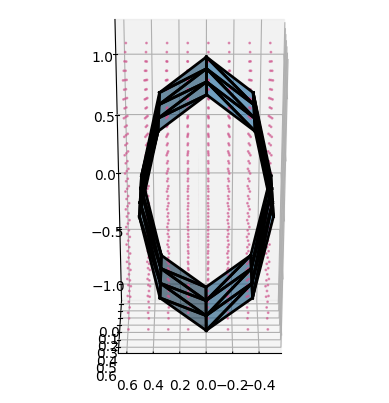

In [46]:
from typing import Tuple, Optional

our_complex = inp.read_obj("input/hinge.obj")
gridd = grid.Grid3.from_complex(our_complex, 0.1, buffer=0.2)
# our_complex = inp.read_obj("input/cylinder.obj")
# gridd = grid.Grid3.from_complex(our_complex, 0.15, buffer=0.05)


state = {}
faustian_edges = []
bad_points = []
call_count = 0
def for_each_edge(new_point: Tuple[int,int,int], old_point: Optional[Tuple[int, int, int]]):
  global call_count
  n_edge_guess = 6 * gridd.a.shape[0] * gridd.a.shape[1] * gridd.a.shape[2]
  print(f'Progress: {int(100 * call_count / n_edge_guess )}%\r', end='')
  call_count += 1
  if old_point is None:
    if gridd.on_boundary(new_point):
      raise Exception('Dont start on the boundary!')
    special_point_a = gridd.coordinate(new_point)
    state[new_point] = vin.initialize_vineyards(our_complex, special_point_a)
  else:
    if gridd.on_boundary(new_point) and gridd.on_boundary(old_point):
      return
    special_point_b = gridd.coordinate(new_point)
    (D, R, U_t, a_ordering) = state[old_point]
    (faustian, new_D, new_R, new_U_t, b_ordering, bad_point) = vin.vine_to_vine(
      D, R, U_t, our_complex, special_point_b, a_ordering, 0, prune=True
    )
    if bad_point is not None:
      bad_points.append(bad_point)
    state[new_point] = (new_D, new_R, new_U_t, b_ordering)
    if faustian:
      faustian_edges.append((old_point, new_point))


start_index = gridd.center_index()
gridd.flood_fill_visit(start_index, for_each_edge)

for azim in [0, 30, 45, 80, 90]:
  fig, ax = plt.subplots(subplot_kw={'projection': '3d', 'computed_zorder': False})
  ax.view_init(azim=azim, elev=30)
  ax.set_aspect('equal')
  ourplot.plot_complex_3d(ax, our_complex)
  ourplot.plot_grid_3d(ax, gridd)
  for (a, b) in faustian_edges:
    [a,b,c,d] = gridd.dual_face(a, b)
    ourplot.plot_face_3d(ax, a,b,c,d,)
  ax.plot(
    [p[0] for p in bad_points],
    [p[1] for p in bad_points],
    [p[2] for p in bad_points],
    'o', markersize=5, color='red'
  )
  ax.set_aspect('equal')

with open('output/obj.obj', 'w') as f:
  vi = 1
  for (a, b) in faustian_edges:
    [a, b, c, d] = gridd.dual_face(a, b)
    f.write(f'v {a[0]} {a[1]} {a[2]}\n')
    f.write(f'v {b[0]} {b[1]} {b[2]}\n')
    f.write(f'v {c[0]} {c[1]} {c[2]}\n')
    f.write(f'v {d[0]} {d[1]} {d[2]}\n')
    f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
    vi += 4



utils.Timed.report()

In [37]:

from typing import Tuple, Optional

our_complex = inp.read_obj("input/hinge.obj")
gridd = grid.Grid3.from_complex(our_complex, 0.1, buffer=0.2)
# our_complex = inp.read_obj("input/cylinder.obj")
# gridd = grid.Grid3.from_complex(our_complex, 0.25, buffer=0.05)


def compare(key):
  (D, R, U_t, _) = state[key]
  (D_DENSE, R_DENSE, U_DENSE, _) = state_DENSE[key]

  if (D.to_dense() != D_DENSE).any():
    print('D not equal')
    print('D.to_dense')
    print(D.to_dense())
    print('D_DENSE')
    print(D_DENSE)
    raise Exception('D not equal')

  if (R.to_dense() != R_DENSE).any():
    print('R not equal')
    print('R.to_dense')
    print(R.to_dense())
    print('R_DENSE')
    print(R_DENSE)
    raise Exception('R not equal')

  if (U_t.to_dense().T != U_DENSE).any():
    print('U not equal')
    print('U_t.to_dense.T')
    print(U_t.to_dense().T)
    print('U_DENSE')
    print(U_DENSE)
    raise Exception('U not equal')


state = {}
state_DENSE = {}
faustian_edges = []
bad_points = []
call_count = 0
def for_each_edge(new_point: Tuple[int,int,int], old_point: Optional[Tuple[int, int, int]]):
  global call_count
  n_edge_guess = 6 * gridd.a.shape[0] * gridd.a.shape[1] * gridd.a.shape[2]
  print(f'Progress: {call_count} / {n_edge_guess }')
  call_count += 1
  if old_point is None:
    if gridd.on_boundary(new_point):
      raise Exception('Dont start on the boundary!')
    special_point_a = gridd.coordinate(new_point)
    state[new_point] = vin.initialize_vineyards(our_complex, special_point_a)
    state_DENSE[new_point] = vin.initialize_vineyards_DENSE(our_complex, special_point_a)
    compare(new_point)
  else:
    if gridd.on_boundary(new_point) and gridd.on_boundary(old_point):
      return
    special_point_b = gridd.coordinate(new_point)

    (D_DENSE, R_DENSE, U_DENSE, a_ordering_DENSE) = state_DENSE[old_point]
    (faustian_DENSE, new_D_DENSE, new_R_DENSE, new_U_t_DENSE, b_ordering_DENSE, bad_point_DENSE) = vin.vine_to_vine_DENSE(
      D_DENSE, R_DENSE, U_DENSE, our_complex, special_point_b, a_ordering_DENSE, 0, prune=False
    )
    state_DENSE[new_point] = (new_D_DENSE, new_R_DENSE, new_U_t_DENSE, b_ordering_DENSE)
    # print('D_DENSE')
    # print(D_DENSE)
    # print('R_DENSE')
    # print(R_DENSE)
    # print('U_DENSE')
    # print(U_DENSE)
    # print('RU_DENSE')
    # print(R_DENSE @ U_DENSE % 2)

    (D, R, U_t, a_ordering) = state[old_point]
    (faustian, new_D, new_R, new_U_t, b_ordering, bad_point) = vin.vine_to_vine(
      D, R, U_t, our_complex, special_point_b, a_ordering, 0, prune=False
    )
    state[new_point] = (new_D, new_R, new_U_t, b_ordering)

    compare(new_point)

    if bad_point is not None:
      bad_points.append(bad_point)
    if faustian:
      faustian_edges.append((old_point, new_point))


start_index = gridd.center_index()
gridd.flood_fill_visit(start_index, for_each_edge)

for azim in [0, 30, 45, 80, 90]:
  fig, ax = plt.subplots(subplot_kw={'projection': '3d', 'computed_zorder': False})
  ax.view_init(azim=azim, elev=30)
  ax.set_aspect('equal')
  ourplot.plot_complex_3d(ax, our_complex)
  ourplot.plot_grid_3d(ax, gridd)
  for (a, b) in faustian_edges:
    [a,b,c,d] = gridd.dual_face(a, b)
    ourplot.plot_face_3d(ax, a,b,c,d,)
  ax.plot(
    [p[0] for p in bad_points],
    [p[1] for p in bad_points],
    [p[2] for p in bad_points],
    'o', markersize=5, color='red'
  )
  ax.set_aspect('equal')

with open('output/obj.obj', 'w') as f:
  vi = 1
  for (a, b) in faustian_edges:
    [a, b, c, d] = gridd.dual_face(a, b)
    f.write(f'v {a[0]} {a[1]} {a[2]}\n')
    f.write(f'v {b[0]} {b[1]} {b[2]}\n')
    f.write(f'v {c[0]} {c[1]} {c[2]}\n')
    f.write(f'v {d[0]} {d[1]} {d[2]}\n')
    f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
    vi += 4



utils.Timed.report()

Progress: 0 / 16464
Progress: 1 / 16464
case 1.1.2
i=2 (0
[[0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
case 1.2
i=3 (1
[[0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
case 2.2
i=5 (2
[[0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0

AssertionError: 